In [ ]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
from math import sqrt
import random
%matplotlib inline

In [ ]:
words = open('names.txt', 'r').read().splitlines()
words[:8], len(words)


(['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia'],
 32033)

In [ ]:
chars = sorted(list(set(''.join(words))))
stio = {s:i+1 for i,s in enumerate(chars)}
stio['.']=0
iots = {i:s for s,i in stio.items()}
vocab_size = len(iots)
print(iots)
print(vocab_size)


{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [ ]:
random.seed(42)
random.shuffle(words)

In [ ]:
block_size = 8
vocab_size = 27

def build_dataset(words):
    
    X, Y = [],[]

    for w in words:
        #print(w)
        context = [0] * block_size
        for ch in w +'.':
            ix = stio[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(iots[i] for i in context),'---->',iots[ix])
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xts, Yts = build_dataset(words[n2:])

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [ ]:
for x,y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(iots[ix.item()] for ix in x), '--->',iots[y.item()])

........ ---> y
.......y ---> u
......yu ---> h
.....yuh ---> e
....yuhe ---> n
...yuhen ---> g
..yuheng ---> .
........ ---> d
.......d ---> i
......di ---> o
.....dio ---> n
....dion ---> d
...diond ---> r
..diondr ---> e
.diondre ---> .
........ ---> x
.......x ---> a
......xa ---> v
.....xav ---> i
....xavi ---> e


In [ ]:

class Linear:
    
    def __init__(self, fan_in, fan_out, bias=True):
        #fan_in is features in , num_dim * Block size & fan_out is features out, num_hidden neurons
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # kaimin initi
        self.bias   = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
#-------------------------------------------------------------------------------------    

class Batchnorm1d:
                
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        #parameters trainied with backdrop
        self.gamma = torch.ones(dim)
        self.beta  = torch.zeros(dim)
        # buffers (trained with runining momentum update) exponential moving average
        self.runining_mean = torch.zeros(dim)
        self.runining_var = torch.ones(dim)
        
        
    def __call__(self,x):
        #forward pass
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim ==3:
                dim =(0,1)
            xmean = x.mean(dim, keepdim=True) # batch mean
            xvar = x.var(dim, keepdim=True) # batch variance
        else:
            xmean = self.runining_mean
            xvar = self.runining_var
        #finding var then sqrt to find std to follow the paper
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalizing to unit variance
        self.out = self.gamma * xhat + self.beta
        #update the buffers
        if self.training:
            #those dont get run if we are in inference 
            with torch.no_grad():
                self.runining_mean = ( 1 - self.momentum) * self.runining_mean + self.momentum * xmean
                self.runining_var = ( 1 - self.momentum) * self.runining_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
#---------------------------------------------------------------------------------------------------------------    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []
#--------------------------------------------------------------------------------------------------------------       
class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))
    
    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    
    def parameters(self):
        return [self.weight]
# ---------------------------------------------------------------------------------------------------------------
class FlattenConseqetive:
    def __init__(self, n):
        self.n = n
        
    def __call__(self,x):
        B,T,C = x.shape
        x = x.view(B,T//self.n,C*self.n)
        if x.shape[1]==1:
            x = x.squeeze(1)
        self.out =x
        return self.out
    
    def parameters(self):
        return []
# ---------------------------------------------------------------------------------------------------------------
class Sequential:
    def __init__(self, layers):
        self.layers = layers
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
        
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
        
        

In [ ]:
# we are opting out of using the generator g instead use torch random seed
torch.manual_seed(42);

In [ ]:
num_embs = [10,24,48]
n_hidden_act = [128,200,300]


for num_emb,n_hidden in zip(num_embs, n_hidden_act):
    print(num_emb,n_hidden)

10 128
24 200
48 300


In [ ]:
num_embs = [10,24,48]
n_hidden_act = [128,200,300]
train_loss = []
val_loss = []

for num_emb,n_hidden in zip(num_embs, n_hidden_act):

#we can call our layers sequentially
    model = Sequential([
        Embedding(vocab_size, num_emb),
        FlattenConseqetive(2),Linear(num_emb*2, n_hidden, bias=False), Batchnorm1d(n_hidden), Tanh(),
        FlattenConseqetive(2),Linear(n_hidden*2, n_hidden, bias=False), Batchnorm1d(n_hidden), Tanh(),
        FlattenConseqetive(2),Linear(n_hidden*2, n_hidden, bias=False), Batchnorm1d(n_hidden), Tanh(),
        Linear(n_hidden, vocab_size),
    ])

    with torch.no_grad():
        model.layers[-1].weight *= 0.1 #last layer make less confident

    parameters = model.parameters()
    print(sum(p.nelement() for p in parameters))

    for p in parameters:
        p.requires_grad = True

    max_steps = 200000
    bs =32 # batch size
    lossi =[]
    ud = []

    for i in range(max_steps):

        #contruct a minibatch
        ix = torch.randint(0,Xtr.shape[0], (bs,))
        xb, yb = Xtr[ix], Ytr[ix] #batch of x and y

        #forward pass
        logits = model(xb)
        loss = F.cross_entropy(logits, yb)

        #backward
        for p in parameters:
            p.grad = None
        loss.backward()

        #updating
        lr = 0.1 if i < 150000 else 0.01    #step learing rate Decay 
        for p in parameters:
            p.data += -lr*p.grad

        #tracking stats
        if i %10000==0:
            print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        lossi.append(loss.log10().item())
    #     with torch.no_grad():
    #         ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])

        #break #after Debug: would take out to run full optimazation
    
    @torch.no_grad()
    def split_loss(split):
        x,y = {
            'train':(Xtr,Ytr),
            'dev': (Xdev,Ydev),
            'test': (Xts, Yts)
        }[split]

        logits = model(x)
        loss = F.cross_entropy(logits,y)
        print(f'{split} {loss.item():.4f}')
        
        
    for layer in model.layers:
        layer.training = False
        
    train_loss.append(split_loss('train'))
    val_loss.append(split_loss('dev'))
    print(train_loss,val_loss)
    
print(zip(train_loss,val_loss))

72617
      0/ 200000: 3.3024
  10000/ 200000: 2.4373
  20000/ 200000: 2.2864
  30000/ 200000: 1.8460
  40000/ 200000: 1.9939
  50000/ 200000: 1.9903
  60000/ 200000: 1.8993
  70000/ 200000: 2.1690
  80000/ 200000: 1.8565
  90000/ 200000: 1.7869
 100000/ 200000: 1.7459
 110000/ 200000: 1.9999
 120000/ 200000: 1.7830
 130000/ 200000: 1.8632
 140000/ 200000: 2.0153
 150000/ 200000: 2.0015
 160000/ 200000: 1.7628
 170000/ 200000: 1.8274
 180000/ 200000: 1.4137
 190000/ 200000: 1.9578
train 1.7987
dev 1.9912
[None] [None]
176875
      0/ 200000: 3.2993
  10000/ 200000: 2.5029
  20000/ 200000: 1.9495
  30000/ 200000: 1.9267
  40000/ 200000: 2.4372
  50000/ 200000: 2.3803
  60000/ 200000: 1.4160
  70000/ 200000: 2.1467
  80000/ 200000: 1.9023
  90000/ 200000: 2.0960
 100000/ 200000: 1.8493
 110000/ 200000: 1.6556
 120000/ 200000: 1.2402
 130000/ 200000: 1.6865
 140000/ 200000: 1.6402
 150000/ 200000: 2.3335
 160000/ 200000: 1.9547
 170000/ 200000: 1.8907
 180000/ 200000: 1.5158
 190000/ 2000

In [ ]:
#plt.plot(lossi);

[<matplotlib.lines.Line2D>]

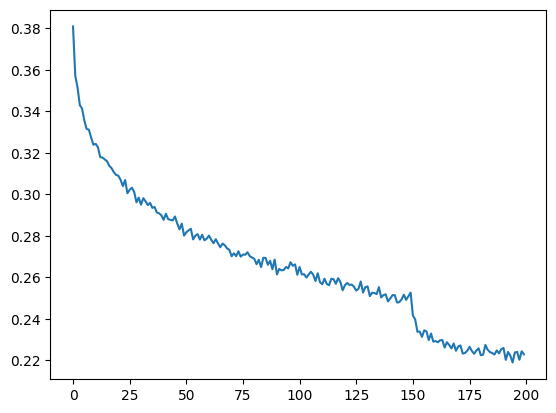

In [ ]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [ ]:
#to put in eval mode, especially for batchnorm to use the xmean from the running_mean
for layer in model.layers:
    layer.training = False

In [ ]:
# test data loss test
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train':(Xtr,Ytr),
        'dev': (Xdev,Ydev),
        'test': (Xts, Yts)
    }[split]
    
    logits = model(x)
    loss = F.cross_entropy(logits,y)
    print(f'{split} {loss.item():.4f}')

split_loss('train')
split_loss('dev')

train 1.6495
dev 2.0154


- performance log

- with num_emb=24, n_hidden = 256 , train 1.6729, dev 2.0000
- with num_emb=10 , n_hidden = 128 , train 1.6729, dev 2.0000

In [ ]:
#sample from the model

for _ in range(20):
    out = []
    context = [0]* block_size # initializing all with ...
    while True:
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, 1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix ==0:
            break
            
    print(''.join(iots[i] for i in out ))

ahmet.
filars.
zeloni.
fawton.
hoda.
lakay.
naryssa.
vlyna.
caitlee.
ashton.
troyal.
irahman.
shrutiz.
piet.
jemiji.
lailynne.
liyathan.
curt.
rihaan.
janeah.
